MRAugmenter 시각화 노트북
이 노트북은 MRAugmenter를 import하여 하나의 k-space 데이터를 증강하고, 다음을 시각화합니다:
1. 원본 k-space (log scale)
2. Augmented k-space (log scale)
3. 원본 RSS 이미지
4. Augmented RSS 이미지 (final_target)
5. Error map (|augmented - original|)
6. Undersampled k-space 및 그로부터 복원한 RSS 이미지

In [1]:
## 1. 공통 Imports 및 Helper 함수

# %%
import os
import glob
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from mraugmenter import MRAugmenter

# FFT 및 RSS helper

def quick_ifft2(kc):
    # k-space -> image-domain IFFT (orthonormal)
    img = np.fft.ifftshift(
        np.fft.ifft2(np.fft.fftshift(kc, axes=(-2,-1)), norm='ortho'),
        axes=(-2,-1)
    )
    return img

def rss(img, axis=0):
    return np.sqrt(np.sum(np.abs(img)**2, axis=axis))


In [2]:
## 2. 데이터 로딩 및 Augmenter 초기화

# %%
# 사용자 환경에 맞게 Data_dir를 수정하세요
Data_dir = "/home/swpants05/Desktop/2025_FastMri/Data"

# train k-space 파일 리스트에서 첫 번째 샘플 선택
ks_paths = glob.glob(os.path.join(Data_dir, "train", "kspace", "*.h5"))
sample_path = ks_paths[0]

# k-space와 mask 로드
with h5py.File(sample_path, 'r') as f:
    kspace_np = f['kspace'][()]    # shape: [coil, H, W]
    mask = f['mask'][()].astype(bool) if 'mask' in f else None

# 원본 RSS target 계산
def compute_target(kc):
    img = quick_ifft2(kc)
    return rss(img, axis=0)

target_np = compute_target(kspace_np)

# MRAugmenter 설정 (예시값 사용)
aug = MRAugmenter(
    aug_on=True,
    aug_strength=0.9,
    aug_schedule_mode='epoch',
    aug_schedule_type='ramp',
    aug_delay=5,
    max_epochs=100,
    aug_exp_decay=6.0,
    val_loss_window_size=5,
    val_loss_grad_start=-0.05,
    val_loss_grad_plateau=-0.001,
    weight_dict={
        'fliph':0.5, 'flipv':0.5, 'rotate':0.25,
        'scale':0.5, 'shift':0.2, 'shear':0.5
    },
    max_rotation_angle=15.0,
    scale_range=(0.85, 1.15),
    shift_extent=5.0,
    max_shear_angle=10.0
)

# 에포크 6로 상태 업데이트하여 aug_delay 이후 상태로 만듦
aug.update_state(current_epoch=6)

# 증강 적용
_, aug_kspace_np, final_target, _, _, _ = aug(
    mask, kspace_np, target_np, None, None, 0
)

ValueError: too many values to unpack (expected 2)

In [ ]:
## 3. 시각화: k-space 및 RSS 이미지

# %%
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# 원본 k-space (log)
axes[0,0].imshow(np.log(np.abs(kspace_np) + 1e-9).sum(axis=0), cmap='gray')
axes[0,0].set_title('Original k-space (log magnitude sum over coils)')
axes[0,0].axis('off')

# Augmented k-space (log)
axes[0,1].imshow(np.log(np.abs(aug_kspace_np) + 1e-9).sum(axis=0), cmap='gray')
axes[0,1].set_title('Augmented k-space (log magnitude sum)')
axes[0,1].axis('off')

# 원본 RSS 이미지
axes[1,0].imshow(target_np, cmap='gray')
axes[1,0].set_title('Original RSS image')
axes[1,0].axis('off')

# Augmented RSS 이미지
axes[1,1].imshow(final_target, cmap='gray')
axes[1,1].set_title('Augmented RSS (final_target)')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
## 4. Error Map (차이 시각화)

# %%
error_map = np.abs(final_target - target_np)
plt.figure(figsize=(4,4))
plt.imshow(error_map, cmap='hot')
plt.title('Error map |aug - orig|')
plt.axis('off')
plt.colorbar(shrink=0.7)
plt.show()


In [ ]:
## 5. Undersampled 데이터 시각화

# %%
if mask is not None:
    # undersampled k-space
    undersampled_kc = aug_kspace_np * mask
    us_img = quick_ifft2(undersampled_kc)
    us_rss = rss(us_img, axis=0)

    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(np.log(np.abs(undersampled_kc) + 1e-9).sum(axis=0), cmap='gray')
    ax[0].set_title('Undersampled k-space (log mag)')
    ax[0].axis('off')

    ax[1].imshow(us_rss, cmap='gray')
    ax[1].set_title('Undersampled RSS image')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Mask not found; undersampling visualization skipped.")


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 5 is not equal to len(dims) = 4

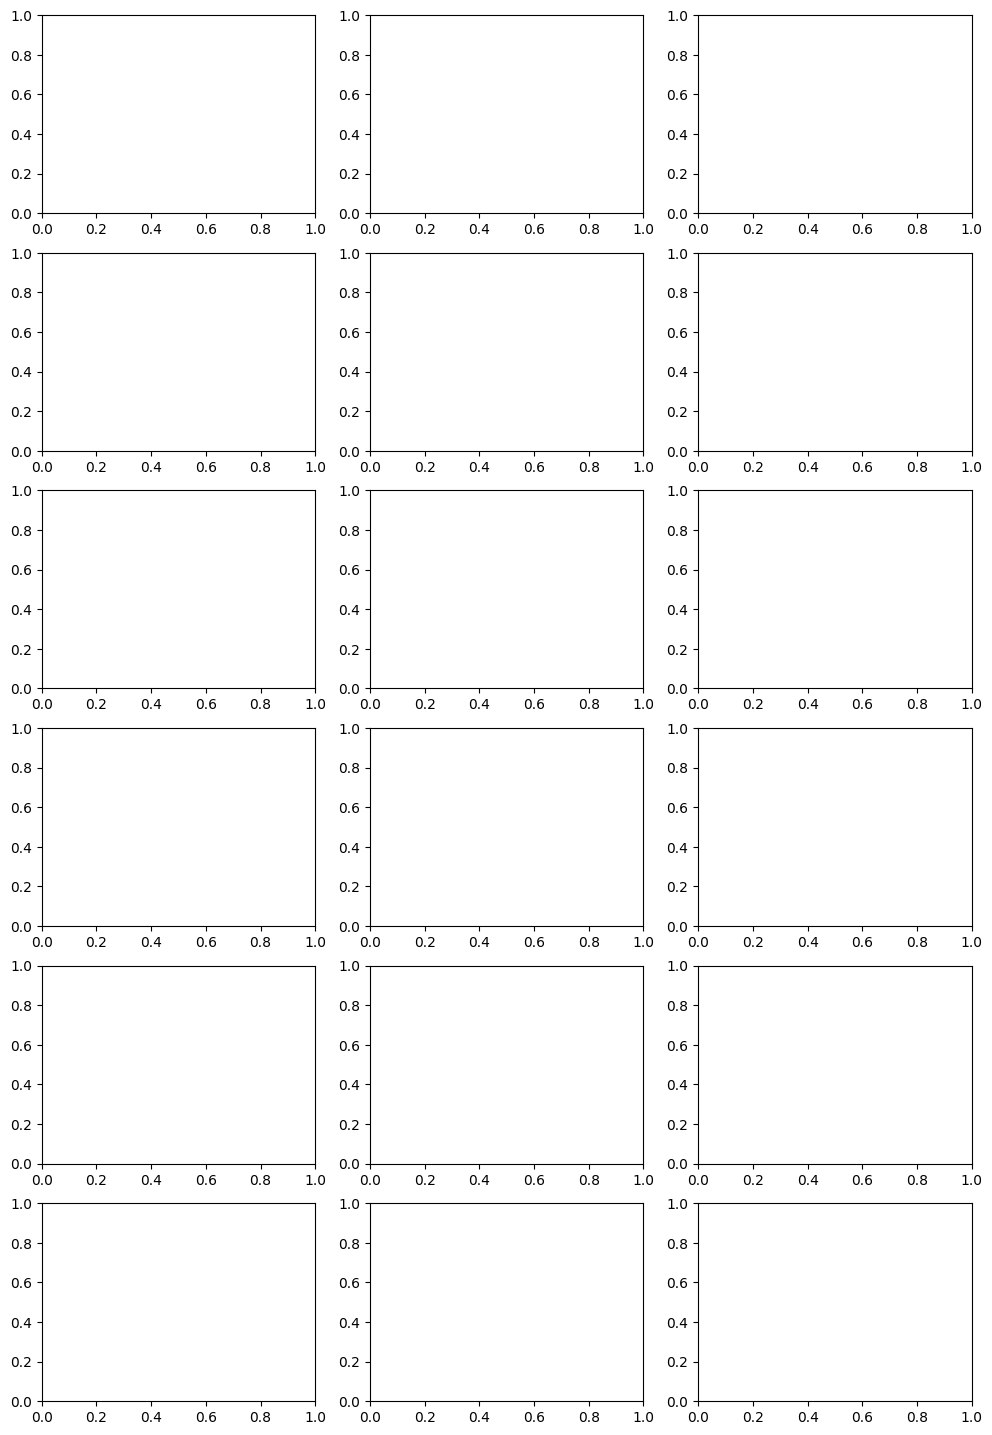

In [3]:
## 6. 개별 변환별 시각화
# 각 변환만 단독 적용하여 k-space, RSS, 에러를 확인합니다.

# %%
# k-space -> image tensor
kspace_tensor = torch.from_numpy(kspace_np).cfloat()
k_unshift = torch.fft.ifftshift(kspace_tensor, dim=(-2,-1))
img_domain = torch.fft.ifft2(k_unshift, norm='ortho')
img = torch.fft.fftshift(img_domain, dim=(-2,-1))

# 변환 함수 매핑
transform_map = {
    'hflip': aug._transform_hflip,
    'vflip': aug._transform_vflip,
    'rotate': aug._transform_rotate,
    'scale': aug._transform_scale,
    'shift': aug._transform_shift,
    'shear': aug._transform_shear
}

n = len(transform_map)
fig, axes = plt.subplots(n, 3, figsize=(12, 3*n))
for i, (name, func) in enumerate(transform_map.items()):
    # 단일 변환 적용
    img_aug = func(img)
    kc_aug = aug._fft(img_aug).numpy()
    target_aug = compute_target(kc_aug)
    err = np.abs(target_aug - target_np)
    
    # k-space
    axes[i,0].imshow(np.log(np.abs(kc_aug).sum(axis=0)+1e-9), cmap='gray')
    axes[i,0].set_title(f'{name} k-space'); axes[i,0].axis('off')
    # RSS
    axes[i,1].imshow(target_aug, cmap='gray')
    axes[i,1].set_title(f'{name} RSS'); axes[i,1].axis('off')
    # Error
    axes[i,2].imshow(err, cmap='hot')
    axes[i,2].set_title(f'{name} error'); axes[i,2].axis('off')

plt.tight_layout(); plt.show()
